# Content

In this lecture I will introduce:
- The programming language Julia
- Using Jupyter notebooks to run computations and present them
- How to compute the orbit of a (deterministic and random) dynamical system in Julia
- How to compute Birkhoff averages
- Automatic differentiation
- Classical algorithm to approximate Lyapunov exponent (non-rigorous)
- How to make animations to show the Central Limit Theorem in action

# Introduction to Julia and Jupyter

In this notebook I will introduce Julia notation and some of its characteristics, so that it is easy for you to follow the next lectures.
The first thing to stress is that Julia is a language with a different approach than 
1. C, C++, Fortran: if possible Julia infers the type of the variables from the context, so code can be written in a generic way and Julia takes care of the details (most of the time)
2. Python: in Python the code is interpreted, so it runs slowly. Julia does the following, once the types are identified Julia compiles the code. So the first run of a program is slow, but all subsequent runs are fast.

We will see this through examples.

But, first, I will introduce some of the commands of Jupyter notebooks. Jupyter notebooks consists of cells, of essentially two types: 
- Markdown cells, where text can be written, 
- Code cells where code is written and run.

You can create a new cell above the selected one by pressing __a__ and below the selected one by pressing __b__ . If you select a cell and press __dd__ this will delete the cell. 

You can edit a cell by pressing __ENTER__ when it is selected and you run the code (or compile the Markdown) in a cell by pressing __SHIFT+ENTER__.
Remark that when you select a Markdown cell and press enter, you 

The key __ESC__ will take you to navigation mode, a mode that allows you to move with your arrows between cells.

By default, new cells are Code cells, if you want to turn a code into Markdown, you enter navigation mode, select the cell and press __m__. To change a Markdown cell to code, enter navigation mode, select the cell and press __y__.

In Markdown cells it is possible to write LaTeX code, as 
$$\frac{1}{N-1}\sum_{i=0}^{N-1}\phi(T^i(x_0))$$
and it is possible to use Markdown syntax, that allows to typeset in a similar way as HTML (while being much simpler).
A good reference for Markdown syntax is 
__[DataCamp Markdown tutorial](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-390929969673:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001655&gclid=Cj0KCQjwjo2JBhCRARIsAFG667V_O7vei8Tvaa0wRyoIgzbUrKtpHLpPVKBPYlXIMr5p4b5YxTvuXZwaApHUEALw_wcB)__.

#### Exercise 1
Create a cell below this one and convert it to a Markdown cell. Make an unordered list with three items: 
- one equation, my favourite is $e^{2\pi i x}-1=0$
- the name of a theorem, my favourite is Birkhoff Ergodic Theorem
- your country of origin, I'm italian but I now live in Brazil.

It is possible also to make an ordered list:
1. $\pi \approx 3.14159$
2. **Perron-Frobenius theorem**
3. I now live in Japan for one year

Now we can start speaking about Julia.
First of all: a line starting with __#__ is a comment.

### Julia: Variable declaration

When working in the Julia shell (called Julia REPL), or in the Jupyter notebook, declaring a variable is really simple, we just write its value with an assignment symbol $=$.

In [77]:
# This is a code cell

x = 1   # interpreted as an integer
println(x)
println(typeof(x))

1
Int64


In [78]:
y = 1.0   #interpreted as an Float64 (corresponding to double in C)
println(y)
println(typeof(y))
println(eps(y)) # gives us the machine epsilon

1.0
Float64
2.220446049250313e-16


## Julia: Declare a function

It is possible to declare functions using the one-line syntax.

We declare now the function 
$$
f(t, x) = t\cdot x\cdot (1-x)
$$

As in mathematical notation, the variables inside the parentheses are the independent variables (the input)
and the function returns an output.

In [101]:
dyn(t, x) = t*x*(1-x)

dyn (generic function with 1 method)

In [102]:
dyn(4, 0.5)

1.0

In [103]:
t = 3.9
x = 0.5

y = dyn(t, x)

0.975

Julia, in general shows as an output the output of the last operation; in our case, the value of $y$.

In the case of more complex functions, it is possible to use the multiline syntax using the keyword `function`

In [104]:
function g(x, y)
    if (x>y)
        return x+y
    elseif (x<0)
        return abs(x)
    else
        return y
    end
end

g (generic function with 1 method)

In [105]:
g(0.1, 0.01)

0.11

In [106]:
g(-1, 17)

1

In [107]:
g(0.1, 17)

17

Sometimes, reading Julia source code you will see something like this. To write the $\alpha$ in the source code I write `\alpha` and then press `TAB`. 

In [108]:
function h(x, t = 1; α = 2.0)
    return t-(1+t)*abs(x)^(α)
end

h (generic function with 2 methods)

This function has two default input variables, i.e., I can call this function without specifying `t` and `\alpha` explictly.

In [109]:
h(0)

1.0

If needed I can call this function with two arguments, the second argument corresponds to the argument `t` in the argument list. 

In [110]:
h(0, 0.9)

0.9

The parameter `\alpha` is a keyword parameter (we declare them after the `;`) and I can set it without changing  
the default value of `t`.

In [111]:
h(0.1, α = 3)

0.998

In [112]:
h(0.1, 0.9, α = 5)

0.899981

### Installing packages and plotting

Before going forward, we would like to install the plotting package for Julia. This can be done in two different ways. Either you go back to the command line, press ] and in the pkg prompt you launch the command "add Plots", or we make visible the Pkg package in our working namespace and use it here. 

Installing a package is something that is needed to be only once for each environment you are using. 
Julia has an environment system, that allows you to have different installed packages and different versions of the packages for different jobs... I will not enter into details here, but it is good to know that we are working in the main julia environment at the moment and there is the possibility of having different environments through the use of the command __activate__.

The following two cells are going to be run only once (in this environment).

In [113]:
using Pkg # this brings Pkg into our working environment

In [114]:
Pkg.add("Plots") # this installs Plots in the active environment

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Function compiling and types

In [123]:
# One line declaration
f(x) = 4x*(1-x)

f (generic function with 2 methods)

We will see now the behaviour of the Just in Time compiler of Julia. The first time we will run the function the function is going to be slow, due to compilation time, the second time it is going to be fast because the function is already compiled. Please remark that each time we change the type of the variables Julia is going to compile a new version.

Another thing worth nothing are macros, that begin with __@__. Macros act on the source code of Julia to change it before compilation. The __@time__ macro can be used in front of a function to have a simple benchmark of its behaviour.

In [124]:
x = BigFloat(π)/4
@time f(x)

  0.003050 seconds (1.36 k allocations: 79.245 KiB, 99.47% compilation time)


0.674191553317453583754020633310465100368744547564908164371607248252805200681412

As you can see, the output shows the fact that most of the time was spent compiling the function.

In [125]:
@time f(x)

  0.000009 seconds (6 allocations: 312 bytes)


0.674191553317453583754020633310465100368744547564908164371607248252805200681412

While up to now we did not speak about the type of variables, under the hood Julia compiles the code, so it infers the type from the context in which we call the function.

We can inspect how Julia infers the types in the code using the macro [@code_warntype](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/#InteractiveUtils.@code_warntype)

In [126]:
@code_warntype f(x)

MethodInstance for f(::BigFloat)
  from f(x) in Main at In[123]:2
Arguments
  #self#::Core.Const(f)
  x::BigFloat
Body::BigFloat
1 ─ %1 = (4 * x)::BigFloat
│   %2 = (1 - x)::BigFloat
│   %3 = (%1 * %2)::BigFloat
└──      return %3



Once the function is compiled, the computation time radically decreases.

Now, we will bring Plots into the namespace, to plot our function. Plots is a big package, and the first time it runs it is going to be slow. This is one of the main issues with Julia, and the time to first plot is a benchmark for new versions of Julia.

In [127]:
using Plots # this brings the plot package into our namespace

  0.004601 seconds (20.59 k allocations: 909.947 KiB, 80.85% compilation time)


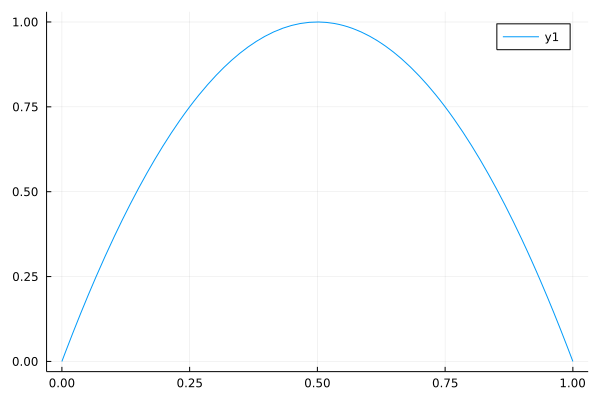

In [128]:
@time plot(f, 0, 1)

The second time, again is much faster.

  0.000920 seconds (9.03 k allocations: 247.969 KiB)


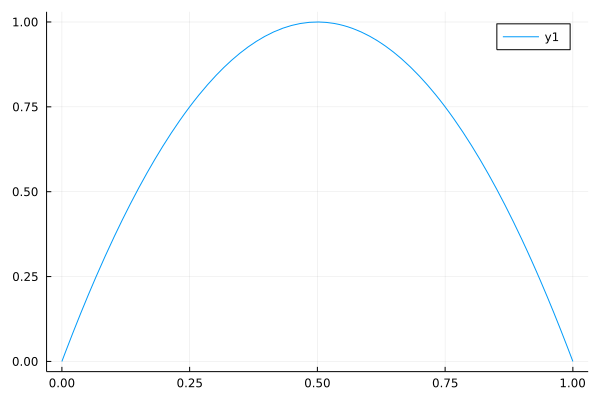

In [129]:
@time plot(f, 0, 1)

## Writing performant code: some notions about variables

We can also specify the type of a variable when we declare it, this helps the compiler infer the right functions and may speed up the code (this requires a version of Julia more recent than 1.8.0).

The reason why this may be necessary is that when using a jupyter notebook (or an interactive programming style), often we define variables in a global scope.
When running the code the compiler need to produce generic code that works for all types, and so the code is slow.

In [4]:
x_int::Int64 = 32 

32

I will present three examples, that show how, knowing some information about the types, Julia can speed up a computation in a significant way.
This example is taken from [Blog by Bogumił Kamiński - Why do I use main function in my Julia scripts?](https://bkamins.github.io/julialang/2022/07/15/main.html)


In the first example, we do not give any hint about the types.

In [21]:
s = 0 
@time for i in 1:10^8
    s+=i
end

  2.134633 seconds (200.00 M allocations: 2.980 GiB, 1.62% gc time)


In the second example we give informations about the type of the variable that we are using to accumulate the sum.

In [31]:
s_int::Int64 = 0
@time for i in 1:10^8
    s_int+=i
end

  0.956814 seconds (100.00 M allocations: 1.490 GiB, 2.05% gc time)


In the third example, we put the computation inside a function, in this case the compiler knows the scope of life of each variable and, given these boundary conditions, can optimize the code.
He check that due to how the function is defined, `s` is and integer and all the operation are integer operations and there are no other possibilities, so he can compile an optimized version of the function (the loop also has a constant length, known at compile time, so he can optimize it a lot).

In [137]:
function inside_function()
    s = 0
    for i in 1:10^8
        s += i
    end
    return s
end

@time inside_function()

  0.057633 seconds


5000000050000000

In [138]:
@code_warntype inside_function()

MethodInstance for inside_function()
  from inside_function() in Main at In[137]:1
Arguments
  #self#::Core.Const(inside_function)
Locals
  @_2::Union{Nothing, Tuple{Int64, Int64}}
  s::Int64
  i::Int64
Body::Int64
1 ─       (s = 0)
│   %2  = Core.apply_type(Base.Val, 8)::Core.Const(Val{8})
│   %3  = (%2)()::Core.Const(Val{8}())
│   %4  = Base.literal_pow(Main.:^, 10, %3)::Core.Const(100000000)
│   %5  = (1:%4)::Core.Const(1:100000000)
│         (@_2 = Base.iterate(%5))
│   %7  = (@_2::Core.Const((1, 1)) === nothing)::Core.Const(false)
│   %8  = Base.not_int(%7)::Core.Const(true)
└──       goto #4 if not %8
2 ┄ %10 = @_2::Tuple{Int64, Int64}
│         (i = Core.getfield(%10, 1))
│   %12 = Core.getfield(%10, 2)::Int64
│         (s = s + i)
│         (@_2 = Base.iterate(%5, %12))
│   %15 = (@_2 === nothing)::Bool
│   %16 = Base.not_int(%15)::Bool
└──       goto #4 if not %16
3 ─       goto #2
4 ┄       return s



We can check what is the code generated by the compiler in this case: remark that the compiler has a lot of information at compile time.

In [144]:
@code_llvm inside_function()

;  @ In[137]:1 within `inside_function`
define i64 @julia_inside_function_6813() #0 {
top:
;  @ In[137]:6 within `inside_function`
  ret i64 5000000050000000
}


The compiler was so smart that he saw that the return value of the function could be determined at compilation time, so the actual compiled version of the function is nothing else than 
`inside_function() = 5000000050000000`.

If you want to have better informations on the timing of the function, there is a package called BenchmarkTools, that allows to get better estimates on the running time of a function (it runs it many times, then averages the time).

In [154]:
import Pkg; Pkg.add("BenchmarkTools")
using BenchmarkTools

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [156]:
@btime inside_function()

  1.890 ns (0 allocations: 0 bytes)


5000000050000000

The functions runs in less than two nanosecond: the compiler was smart enough to identify that the end result was constant and substituted the function by a constant at compile time.

We will come back to how to define functions, but I think it is important to understand that a lot of the ideas behind writing fast code in Julia depend on giving the right hints to the compiler.
In other words, the compiler is really smart, but everybody needs some help sometimes.

What is important to remember is:
**Try to avoid global variables, and if performance is important, write functions**

As a good practice, it is good to encapsulate code in functions.

### Floating point numbers

The functions [bitstring](https://docs.julialang.org/en/v1/base/numbers/#Base.bitstring), [nextfloat](https://docs.julialang.org/en/v1/base/numbers/#Base.nextfloat), [prevfloat](https://docs.julialang.org/en/v1/base/numbers/#Base.prevfloat) can be used to explore the structure of the floating point numbers.
The behavior of floating point numbers is delicate, I recommend this beautiful article [What Every Computer Scientist
Should Know About Floating Point
Arithmetic](https://docs.oracle.com/cd/E19957-01/800-7895/800-7895.pdf)

A Float64 number is a sequence of $64$ bits, whose first bit represents the sign $s$, the successive $11$ digits represent a binary number $e$, called the exponent, and the remaining $52$ bits $(d_{52}, \ldots, d_0)$ are the so called mantissa $m$, and represent a binary number of the form 
$$
1+\sum_{i=1}^{52}d_{52-i}\frac{1}{2^{i}}
$$

The number is then represented as 
$$
(-1)^{s}\cdot 2^{e-1023}\cdot m
$$


In [157]:
y = 1.0

1.0

In [158]:
bs = bitstring(y)

"0011111111110000000000000000000000000000000000000000000000000000"

In [159]:
s = parse(Int, "$(bs[1])"; base=2)

0

We parse the exponent part of the bitstring.

In [160]:
e = parse(Int, "$(bs[2:12])"; base=2)

1023

We parse now the mantissa part.

In [161]:
m = 1+parse(Int, "$(bs[13:end])"; base=2)*2^(-52)

1.0

We can now reconstruct our number, i.e.,

In [64]:
(-1)^s*2.0^(e-1023)*m

1.0

We observe now what happens when we take the next floating point number.

In [65]:
bitstring(nextfloat(y))

"0011111111110000000000000000000000000000000000000000000000000001"

In [162]:
nextfloat(y)

1.0000000000000002

Remark that Floating point numbers are few: it is important to recall that numerical computations involve rounding, so to make them mathematically rigorous we need to use tools as [Interval Arithmetic](https://www.amazon.com/Validated-Numerics-Introduction-Rigorous-Computations/dp/069124765X) (this is a link to the book by Prof. Tucker).

In [163]:
bitstring(prevfloat(y))

"0011111111101111111111111111111111111111111111111111111111111111"

In [164]:
bitstring(prevfloat(-y))

"1011111111110000000000000000000000000000000000000000000000000001"

It is important to understand how Julia treats mixed operations, i.e., operations between a Float and an Integer. 

In Julia, types are a fundamental object of the language, it is possible to operate on them and create a hierarchy of types, establish convertion and promotion rules. In the case of an Int64 and a Float64 Point, the two numbers are considered Real Numbers, so Julia converts the Int64 to a Float64.

In [165]:
z = x + y # Julia automatically promotes the Int64 type to a Float64 type, to make sense of this operation
println(z)
println(typeof(z))

1.78539816339744830961566084581987572104929234984377645524373614807695410157155
BigFloat


In [168]:
@code_lowered x+y

CodeInfo(
1 ─       z = Base.MPFR.BigFloat()
│   %2  = Core.apply_type(Base.MPFR.Ref, Base.MPFR.BigFloat)
│   %3  = Base.cconvert(%2, z)
│   %4  = Core.apply_type(Base.MPFR.Ref, Base.MPFR.BigFloat)
│   %5  = Base.cconvert(%4, x)
│   %6  = Base.cconvert(Base.MPFR.Cdouble, c)
│   %7  = Base.getindex(Base.MPFR.ROUNDING_MODE)
│   %8  = Base.cconvert(Base.MPFR.MPFRRoundingMode, %7)
│   %9  = Core.apply_type(Base.MPFR.Ref, Base.MPFR.BigFloat)
│   %10 = Base.unsafe_convert(%9, %3)
│   %11 = Core.apply_type(Base.MPFR.Ref, Base.MPFR.BigFloat)
│   %12 = Base.unsafe_convert(%11, %5)
│   %13 = Base.unsafe_convert(Base.MPFR.Cdouble, %6)
│   %14 = Base.unsafe_convert(Base.MPFR.MPFRRoundingMode, %8)
│         $(Expr(:foreigncall, :(Core.tuple("mpfr_add_d", :libmpfr)), Int32, svec(Ref{BigFloat}, Ref{BigFloat}, Float64, Base.MPFR.MPFRRoundingMode), 0, :(:ccall), :(%10), :(%12), :(%13), :(%14), :(%8), :(%6), :(%5), :(%3)))
└──       return z
)

In [169]:
?promote

search: promote promote_type promote_rule promote_shape portfoliocomposition



```
promote(xs...)
```

Convert all arguments to a common type, and return them all (as a tuple). If no arguments can be converted, an error is raised.

See also: [`promote_type`], [`promote_rule`].

# Examples

```jldoctest
julia> promote(Int8(1), Float16(4.5), Float32(4.1))
(1.0f0, 4.5f0, 4.1f0)
```


In [170]:
@less promote(x, y)

# This file is a part of Julia. License is MIT: https://julialang.org/license

## type join (closest common ancestor, or least upper bound) ##

"""
    typejoin(T, S)

Return the closest common ancestor of `T` and `S`, i.e. the narrowest type from which
they both inherit.
"""
typejoin() = Bottom
typejoin(@nospecialize(t)) = t
typejoin(@nospecialize(t), ts...) = (@_pure_meta; typejoin(t, typejoin(ts...)))
function typejoin(@nospecialize(a), @nospecialize(b))
    @_pure_meta
    if isa(a, TypeVar)
        return typejoin(a.ub, b)
    elseif isa(b, TypeVar)
        return typejoin(a, b.ub)
    elseif a <: b
        return b
    elseif b <: a
        return a
    elseif isa(a, UnionAll)
        return UnionAll(a.var, typejoin(a.body, b))
    elseif isa(b, UnionAll)
        return UnionAll(b.var, typejoin(a, b.body))
    elseif isa(a, Union)
        return typejoin(typejoin(a.a, a.b), b)
    elseif isa(b, Union)
        return typejoin(a, typejoin(b.a, b.b))
    end
    # a and b are DataTy

Guess what an appropriate container eltype would be for storing results of
`f(::argtypes...)`. The guess is in part based on type inference, so can change any time.

!!! warning
    Due to its fragility, use of `promote_op` should be avoided. It is preferable to base
    the container eltype on the type of the actual elements. Only in the absence of any
    elements (for an empty result container), it may be unavoidable to call `promote_op`.
"""
promote_op(f, S::Type...) = _return_type(f, Tuple{S...})

## catch-alls to prevent infinite recursion when definitions are missing ##

no_op_err(name, T) = error(name," not defined for ",T)
(+)(x::T, y::T) where {T<:Number} = no_op_err("+", T)
(*)(x::T, y::T) where {T<:Number} = no_op_err("*", T)
(-)(x::T, y::T) where {T<:Number} = no_op_err("-", T)
(/)(x::T, y::T) where {T<:Number} = no_op_err("/", T)
(^)(x::T, y::T) where {T<:Number} = no_op_err("^", T)

fma(x::T, y::T, z::T) where {T<:Number} = no_op_err("fma", T)
fma(x::Integer, y::Integer,

In [171]:
supertypes(Float64)

(Float64, AbstractFloat, Real, Number, Any)

In [172]:
supertypes(Int64)

(Int64, Signed, Integer, Real, Number, Any)

In [173]:
# we can also create variables with explicit types
x = BigFloat("0.1") # these are MPFR high precision numbers
println(x)
println(typeof(x))
println(precision(x)) #get the precision in bit of the mantissa of x

0.1000000000000000000000000000000000000000000000000000000000000000000000000000002
BigFloat
256


It is important to observe that $0.1$ has no exact representation in base $2$ floating point arithmetic.

If needed, in the REPL, the documentation is obtained by prepending a ? to the name of a function: we are interested in the function setprecision

In [174]:
?setprecision

search: setprecision



```
setprecision([T=BigFloat,] precision::Int; base=2)
```

Set the precision (in bits, by default) to be used for `T` arithmetic. If `base` is specified, then the precision is the minimum required to give at least `precision` digits in the given `base`.

!!! warning
    This function is not thread-safe. It will affect code running on all threads, but its behavior is undefined if called concurrently with computations that use the setting.


!!! compat "Julia 1.8"
    The `base` keyword requires at least Julia 1.8.


---

```
setprecision(f::Function, [T=BigFloat,] precision::Integer; base=2)
```

Change the `T` arithmetic precision (in the given `base`) for the duration of `f`. It is logically equivalent to:

```
old = precision(BigFloat)
setprecision(BigFloat, precision)
f()
setprecision(BigFloat, old)
```

Often used as `setprecision(T, precision) do ... end`

Note: `nextfloat()`, `prevfloat()` do not use the precision mentioned by `setprecision`.

!!! compat "Julia 1.8"
    The `base` keyword requires at least Julia 1.8.



In [175]:
setprecision(BigFloat, 1024) # if you run a cell, the output of the last line is given by the cell

1024

In [176]:
y = BigFloat("1.0") # these are MPFR high precision numbers
println(y)
println(typeof(y))
println(precision(y)) #get the precision in bit of the mantissa of x

1.0
BigFloat
1024


In [177]:
z = x+y
precision(z) 
# the output of the last line is given by the cell, here Julia took care of promoting the type 
# to guarantee no precision loss

1024

In [178]:
x = Float64(π) # to write π, I wrote \pi and pressed the tab key; using this Unicode character
#tells Julia to compute the constant adequate for the type precision

3.141592653589793

In [179]:
x = BigFloat(π) 

3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997

In [180]:
@code_native 1.0+1.0

	.text
	.file	"+"
	.globl	"julia_+_7490"                  # -- Begin function julia_+_7490
	.p2align	4, 0x90
	.type	"julia_+_7490",@function
"julia_+_7490":                         # @"julia_+_7490"
; ┌ @ float.jl:383 within `+`
	.cfi_startproc
# %bb.0:                                # %top
	vaddsd	%xmm1, %xmm0, %xmm0
	retq
.Lfunc_end0:
	.size	"julia_+_7490", .Lfunc_end0-"julia_+_7490"
	.cfi_endproc
; └
                                        # -- End function
	.section	".note.GNU-stack","",@progbits


In [181]:
@code_native big"0.1"+big"0.1"

	.text
	.file	"+"
	.globl	"julia_+_7502"                  # -- Begin function julia_+_7502
	.p2align	4, 0x90
	.type	"julia_+_7502",@function
"julia_+_7502":                         # @"julia_+_7502"
; ┌ @ mpfr.jl:386 within `+`
	.cfi_startproc
# %bb.0:                                # %top
	pushq	%r15
	.cfi_def_cfa_offset 16
	pushq	%r14
	.cfi_def_cfa_offset 24
	pushq	%r13
	.cfi_def_cfa_offset 32
	pushq	%r12
	.cfi_def_cfa_offset 40
	pushq	%rbx
	.cfi_def_cfa_offset 48
	subq	$32, %rsp
	.cfi_def_cfa_offset 80
	.cfi_offset %rbx, -48
	.cfi_offset %r12, -40
	.cfi_offset %r13, -32
	.cfi_offset %r14, -24
	.cfi_offset %r15, -16
	vxorps	%xmm0, %xmm0, %xmm0
	vmovaps	%xmm0, (%rsp)
	movq	$0, 16(%rsp)
	#APP
	movq	%fs:0, %rax
	#NO_APP
	movq	%rsp, %rcx
	movabsq	$140385725700176, %r13          # imm = 0x7FAE194FD850
	movq	%rdi, %r15
	movq	%rsi, %r14
	movq	-8(%rax), %r12
; │ @ mpfr.jl:387 within `+`
; │┌ @ mpfr.jl:110 within `BigFloat`
; ││┌ @ refvalue.jl:56 within `getindex`
; │││┌ @ Base.jl:38 within `

#### Exercise 2:
Create two variables x and y, of type Float64 and type BigFloat respectively, both with value $\pi$.
Compute x-y.

## Computing an orbit

We start now to use the tools we have at our disposal to do some numerical experiments.
The first thing we want to do is to compute an $x, f(x), \ldots, f^{n-1}(x)$ for an initial point $x$.

In [190]:
function orbit_float(f, x::Float64, n::Int64)
    orb = Array{Float64, 1}(undef, n) #this declares an uninitialized vector
    orb[1] = x
    for i in 2:n
        x = f(x)
        orb[i] = x
    end
    return orb
end

orbit_float (generic function with 1 method)

Remark that this time I specified the type of the arguments of the function, i.e., the initial point is a `Float64`,
and the orbit is stored as an array of `Float64`.

We compute an orbit of length $100$ for the point $x=0.1$.

In [191]:
v100 = orbit_float(f, 0.1, 100)

100-element Vector{Float64}:
 0.1
 0.36000000000000004
 0.9216
 0.28901376000000006
 0.8219392261226498
 0.5854205387341974
 0.970813326249438
 0.11333924730376121
 0.4019738492975123
 0.9615634951138128
 0.1478365599132853
 0.5039236458651636
 0.9999384200124991
 ⋮
 0.9545172316980255
 0.17365634435825364
 0.5739992736895251
 0.9780964299736911
 0.08569521458564608
 0.3134061791310646
 0.8607309840541266
 0.4794926285733658
 0.9983177908686801
 0.0067175172150335735
 0.026689568709997204
 0.10390894252828617

The following is a Time Series plot of the orbit of the point $0.1$ under the action of the dynamics.

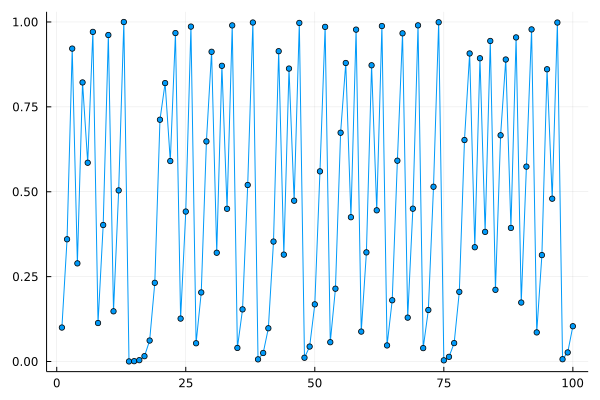

In [192]:
plot(v100, markershape = :circle, markersize = 3, label = "")

## Generic code

We are interested now in changing the type of the inital point, to a multiprecision floating point number.

In [193]:
function orbit_mpfr(f, x::BigFloat, n::Int64)
    orb = Array{BigFloat, 1}(undef, n) #this declares an uninitialized vector
    orb[1] = x
    for i in 2:n
        x = f(x)
        orb[i] = x
    end
    return orb
end

orbit_mpfr (generic function with 1 method)

If we compare the two functions, they are essentially the same: the only point where we use the type of the initial point `x` is to decide the type of the element of the `orb` vector.
The only thing that we really need is that the type of `x` and of the element of `orb` is the same.
So, we can do the following and let the compiler take care of everything.

In [195]:
function orbit(f, x, n)
    v = Array{typeof(x), 1}(undef, n) #this declares an uninitialized vector
    v[1] = x
    for i in 2:n
        x = f(x)
        v[i] = x
    end
    return v
end

orbit (generic function with 2 methods)

The code I wrote above is generic; indeed, if I change the type of the x point, the code once with Float64 and run again but with a different type the compiler will compile it for this new type. Here I compute the orbit of the same point, but using higher precision Floating Point numbers, that Julia calls BigFloats and rely on the MPFR library.

In [200]:
v2000 = orbit(f, 0.1, 2000)

2000-element Vector{Float64}:
 0.1
 0.36000000000000004
 0.9216
 0.28901376000000006
 0.8219392261226498
 0.5854205387341974
 0.970813326249438
 0.11333924730376121
 0.4019738492975123
 0.9615634951138128
 0.1478365599132853
 0.5039236458651636
 0.9999384200124991
 ⋮
 0.6128641149506132
 0.9490467662256591
 0.1934280069691131
 0.6240544523562793
 0.9384419714023345
 0.23107455085133785
 0.7107164112007613
 0.8223943762026866
 0.5842474647715222
 0.9716094587182845
 0.11033807378978674
 0.39265433304858527

In [201]:
@code_warntype orbit(f, 0.1, 2000)

MethodInstance for orbit(::typeof(f), ::Float64, ::Int64)
  from orbit(f, x::Float64, n::Int64) in Main at In[185]:1
Arguments
  #self#::Core.Const(orbit)
  f::Core.Const(f)
  x@_3::Float64
  n::Int64
Locals
  @_5::Union{Nothing, Tuple{Int64, Int64}}
  orb::Vector{Float64}
  i::Int64
  x@_8::Float64
Body::Vector{Float64}
1 ─       (x@_8 = x@_3)
│   %2  = Core.apply_type(Main.Array, Main.Float64, 1)::Core.Const(Vector{Float64})
│         (orb = (%2)(Main.undef, n))
│         Base.setindex!(orb, x@_8, 1)
│   %5  = (2:n)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(2), Int64])
│         (@_5 = Base.iterate(%5))
│   %7  = (@_5 === nothing)::Bool
│   %8  = Base.not_int(%7)::Bool
└──       goto #4 if not %8
2 ┄ %10 = @_5::Tuple{Int64, Int64}
│         (i = Core.getfield(%10, 1))
│   %12 = Core.getfield(%10, 2)::Int64
│         (x@_8 = (f)(x@_8))
│         Base.setindex!(orb, x@_8, i)
│         (@_5 = Base.iterate(%5, %12))
│   %16 = (@_5 === nothing)::Bool
│   %17 = Base.not_int(%16)

In [202]:
@time v2000 = orbit(f, BigFloat("0.1"), 2000);

  0.001120 seconds (12.00 k allocations: 1.205 MiB)


In [203]:
@code_warntype orbit(f, BigFloat("0.1"), 2000);

MethodInstance for orbit(::typeof(f), ::BigFloat, ::Int64)
  from orbit(f, x, n) in Main at In[195]:1
Arguments
  #self#::Core.Const(orbit)
  f::Core.Const(f)
  x@_3::BigFloat
  n::Int64
Locals
  @_5::Union{Nothing, Tuple{Int64, Int64}}
  v::Vector{BigFloat}
  i::Int64
  x@_8::BigFloat
Body::Vector{BigFloat}
1 ─       (x@_8 = x@_3)
│   %2  = Main.typeof(x@_8)::Core.Const(BigFloat)
│   %3  = Core.apply_type(Main.Array, %2, 1)::Core.Const(Vector{BigFloat})
│         (v = (%3)(Main.undef, n))
│         Base.setindex!(v, x@_8, 1)
│   %6  = (2:n)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(2), Int64])
│         (@_5 = Base.iterate(%6))
│   %8  = (@_5 === nothing)::Bool
│   %9  = Base.not_int(%8)::Bool
└──       goto #4 if not %9
2 ┄ %11 = @_5::Tuple{Int64, Int64}
│         (i = Core.getfield(%11, 1))
│   %13 = Core.getfield(%11, 2)::Int64
│         (x@_8 = (f)(x@_8))
│         Base.setindex!(v, x@_8, i)
│         (@_5 = Base.iterate(%6, %13))
│   %17 = (@_5 === nothing)::Bool
│   %

In [204]:
v2000[end]

0.9357148661240227193279102925421833860690804866602045303324247568355793832330493827950650660700308674829663194768614766327689995718028398914693770757563177353408043420172043172258678460166846127549432942746793019733906294926428825218106722672697903569018270842188946926606869104168214681325730563230585628277897

The following is an histogram plot for the distribution of first $2000$ iterates of the orbit of the point $0.1$
under the action of the dynamic, compared to the invariant density of the map, which is known explictly 
to be
$$
f(x)=\frac{1}{\pi\sqrt{x(1-x)}}
$$

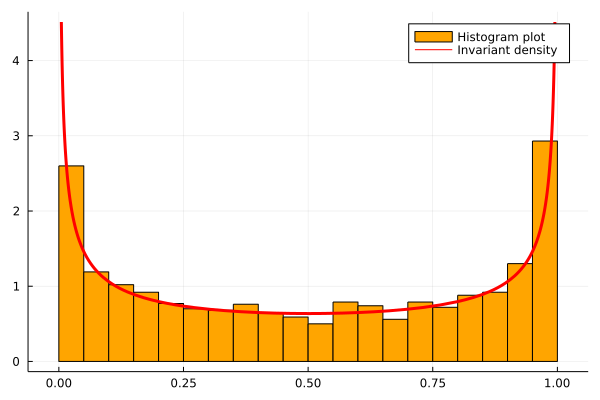

In [205]:
histogram(v2000, bins = 20, normalize = true, label = "Histogram plot", color = :orange)
plot!(x-> 1/(π*sqrt(x*(1-x))), color = :red, 0.005 , 0.995, linewidth = 3, label = "Invariant density" )

Let's take a closer look to how I implemented the code; the important line is the following

```v = Array{typeof(x), 1}(undef, n)```

the Array type is a classical array, as we usually see in C, C++, Fortran.
This is a parametric type and what is written inside __{__ and __}__ are the parameters of this type.
This is going to be an array of elements which have the same type as $x$ of dimension 1.

Inside __(__ and __)__ are the arguments of the function:
- undef tells us tha the Array is going to be uninitialized
- n is the length of the array

In [206]:
z = Array{Int64, 1}(undef, 10) #remark that it is uninitialized, so it contains garbage!!! Be careful!

10-element Vector{Int64}:
 140378106401968
 140378086055056
 140377703815952
 140378086060048
 140378106402544
 140378106402592
 140378106402640
 140378086059536
 140378086059600
 140378086059664

In [207]:
z = zeros(Int64, 10) # initializes the array to 0

10-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [208]:
z = ones(Int64, 10) # initializes the array to 1

10-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

If we want to initalize and array to a specific value, we use the function fill. I will print on screen the documentation thorugh the use of Julia help.

In [209]:
?fill

search: fill fill! finally findall filter filter! filesize filemode isfile



```
fill(value, dims::Tuple)
fill(value, dims...)
```

Create an array of size `dims` with every location set to `value`.

For example, `fill(1.0, (5,5))` returns a 5×5 array of floats, with `1.0` in every location of the array.

The dimension lengths `dims` may be specified as either a tuple or a sequence of arguments. An `N`-length tuple or `N` arguments following the `value` specify an `N`-dimensional array. Thus, a common idiom for creating a zero-dimensional array with its only location set to `x` is `fill(x)`.

Every location of the returned array is set to (and is thus [`===`](@ref) to) the `value` that was passed; this means that if the `value` is itself modified, all elements of the `fill`ed array will reflect that modification because they're *still* that very `value`. This is of no concern with `fill(1.0, (5,5))` as the `value` `1.0` is immutable and cannot itself be modified, but can be unexpected with mutable values like — most commonly — arrays.  For example, `fill([], 3)` places *the very same* empty array in all three locations of the returned vector:

```jldoctest
julia> v = fill([], 3)
3-element Vector{Vector{Any}}:
 []
 []
 []

julia> v[1] === v[2] === v[3]
true

julia> value = v[1]
Any[]

julia> push!(value, 867_5309)
1-element Vector{Any}:
 8675309

julia> v
3-element Vector{Vector{Any}}:
 [8675309]
 [8675309]
 [8675309]
```

To create an array of many independent inner arrays, use a [comprehension](@ref man-comprehensions) instead. This creates a new and distinct array on each iteration of the loop:

```jldoctest
julia> v2 = [[] for _ in 1:3]
3-element Vector{Vector{Any}}:
 []
 []
 []

julia> v2[1] === v2[2] === v2[3]
false

julia> push!(v2[1], 8675309)
1-element Vector{Any}:
 8675309

julia> v2
3-element Vector{Vector{Any}}:
 [8675309]
 []
 []
```

See also: [`fill!`](@ref), [`zeros`](@ref), [`ones`](@ref), [`similar`](@ref).

# Examples

```jldoctest
julia> fill(1.0, (2,3))
2×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0

julia> fill(42)
0-dimensional Array{Int64, 0}:
42

julia> A = fill(zeros(2), 2) # sets both elements to the same [0.0, 0.0] vector
2-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [0.0, 0.0]

julia> A[1][1] = 42; # modifies the filled value to be [42.0, 0.0]

julia> A # both A[1] and A[2] are the very same vector
2-element Vector{Vector{Float64}}:
 [42.0, 0.0]
 [42.0, 0.0]
```


In [210]:
fill(3, 10) # this one fills an array with the first argument, the type of the Array is inferred from the value

10-element Vector{Int64}:
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

As you can see, this allows us for a lot of flexibility in writing code. My code above also works for Rational numbers.

In [211]:
1//7 #this is the rational 1/7

1//7

In [212]:
orbit(f, 1//10, 5) # we don't take an orbit of length 10 because it gives an overflow in Int64

5-element Vector{Rational{Int64}}:
            1//10
            9//25
          576//625
       112896//390625
 125417972736//152587890625

In [213]:
orbit(f, BigInt(1)//BigInt(10), 10)

10-element Vector{Rational{BigInt}}:
                                                                                                                                                                                                                                                                                                                                                                      1//10
                                                                                                                                                                                                                                                                                                                                                                      9//25
                                                                                                                                                                                                                                           

If you look back at all the examples in which we computed the orbit, the output contains the type of the elements of the array.

In the last one, the output is of type:
```10-element Vector{Rational{BigInt}}:```

## Vectorizing the functions

Another interesting possibility is the possibility of vectorizing the functions, using the __.__ before the arguments of the functions.

In [44]:
x = rand(10) # I take 10 random initial points
orbit.(f, x, 10) # this is going to compute the orbits for these ten points

10-element Vector{Vector{Float64}}:
 [0.912688276554612, 0.3187535455775362, 0.868598891037143, 0.4565394301047534, 0.9924447154575216, 0.02999280887184253, 0.11637296115127863, 0.4113211802566465, 0.9685442677157031, 0.12186507676302208]
 [0.6548513396090724, 0.9040842504851029, 0.3468636740395705, 0.9061970626853644, 0.3400157850631287, 0.8976202038841319, 0.36759269385256554, 0.9298732211151183, 0.2608360550724505, 0.7712024297867683]
 [0.09316195116252013, 0.33793120807244936, 0.8949348267325772, 0.376105930534837, 0.9386010382054455, 0.23051651714042137, 0.7095146098634848, 0.824414513015007, 0.5790208949809433, 0.975022792625643]
 [0.710221881353715, 0.8232270424004183, 0.5820971162443127, 0.9730402540174712, 0.10493167231634534, 0.37568406584496183, 0.9381821940606409, 0.23198545923281153, 0.7126728237494122, 0.8190810801538058]
 [0.698812375766519, 0.8418945569682897, 0.5324324476618275, 0.9957925453546512, 0.016759007883024427, 0.0659125741512046, 0.24627242687986625, 0.742489

Suppose now that we want to write a specialized version of the orbit function that returns, instead of an array of arrays a matrix, when we feed it a vector of initial conditions.

To do so, we specialize one of the arguments, i.e., we tell to the compiler that when x is of type 
```Vector{Float64}``` (which is the same as ```Array{Float64, 1}```) we want this specific version of the function orbit to be run.
The compiler is smart, and is going to choose the most specific version of the function.

In [216]:
function orbit(f, x::Vector{Float64}, n)
    k = length(x)
    v = Array{Float64, 2}(undef, (n, k)) 
    v[1, :] = x
    for i in 2:n
        x = f.(x)
        v[i, :] = x
    end
    return v
end

orbit (generic function with 3 methods)

In [218]:
@which orbit(f, 0.1, 10)

orbit(f, x::Float64, n::Int64) in Main at In[185]:1

In [219]:
@which orbit(f, [0.1, 0.2], 10)

orbit(f, x::Vector{Float64}, n) in Main at In[216]:1

The compiler is calling different implementations of the function, depending on the type of the arguments.
We will compute the orbit of ten random initial conditions.

In [223]:
?rand

search: rand randn rand! randn! randexp Random randperm randexp! randperm!



```
rand([rng=GLOBAL_RNG], [S], [dims...])
```

Pick a random element or array of random elements from the set of values specified by `S`; `S` can be

  * an indexable collection (for example `1:9` or `('x', "y", :z)`),
  * an `AbstractDict` or `AbstractSet` object,
  * a string (considered as a collection of characters), or
  * a type: the set of values to pick from is then equivalent to `typemin(S):typemax(S)` for integers (this is not applicable to [`BigInt`](@ref)), to $[0, 1)$ for floating point numbers and to $[0, 1)+i[0, 1)$ for complex floating point numbers;

`S` defaults to [`Float64`](@ref). When only one argument is passed besides the optional `rng` and is a `Tuple`, it is interpreted as a collection of values (`S`) and not as `dims`.

!!! compat "Julia 1.1"
    Support for `S` as a tuple requires at least Julia 1.1.


# Examples

```julia-repl
julia> rand(Int, 2)
2-element Array{Int64,1}:
 1339893410598768192
 1575814717733606317

julia> using Random

julia> rand(MersenneTwister(0), Dict(1=>2, 3=>4))
1=>2

julia> rand((2, 3))
3

julia> rand(Float64, (2, 3))
2×3 Array{Float64,2}:
 0.999717  0.0143835  0.540787
 0.696556  0.783855   0.938235
```

!!! note
    The complexity of `rand(rng, s::Union{AbstractDict,AbstractSet})` is linear in the length of `s`, unless an optimized method with constant complexity is available, which is the case for `Dict`, `Set` and dense `BitSet`s. For more than a few calls, use `rand(rng, collect(s))` instead, or either `rand(rng, Dict(s))` or `rand(rng, Set(s))` as appropriate.



In [224]:
using Random
orbit(f, rand(MersenneTwister(0), 10), 10)

10×10 Matrix{Float64}:
 0.823648  0.910357   0.164566    0.177329  …  0.0682693  0.361828  0.973216
 0.581009  0.32643    0.549936    0.583533     0.254434   0.923634  0.104265
 0.97375   0.879494   0.990026    0.972089     0.75879    0.282135  0.373575
 0.102244  0.423938   0.0394991   0.108529     0.732111   0.81014   0.936067
 0.367159  0.976858   0.151756    0.387001     0.784498   0.615252  0.239383
 0.929413  0.0904257  0.514903    0.948925  …  0.676245   0.946868  0.728314
 0.262417  0.328996   0.999112    0.193864     0.875751   0.201237  0.791491
 0.774218  0.88303    0.00355051  0.625124     0.435244   0.642962  0.660133
 0.699219  0.413152   0.0141516   0.937376     0.983227   0.918247  0.89743
 0.841248  0.96983    0.0558055   0.23481      0.0659683  0.300277  0.368199

In [225]:
v = orbit(f, rand(1000), 200); #the semicomma disables the output

The following animation shows how $1000$ uniformly distributed initial points distribute themselves under iteration of the map $f$. Doing animations is quite simple, what we do is to make a for cycle that generates plots, and use a Julia macro to decorate the code.

In [226]:
?animate

search: animate @animate Animation



Animate from an iterator which returns the plot args each iteration.


┌ Info: Saved animation to 
│   fn = /home/isaia/code/JuliaDSTutorial/tutorial_anim_fps30.gif
└ @ Plots /home/isaia/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/isaia/code/JuliaDSTutorial/tutorial_anim_fps30.gif")
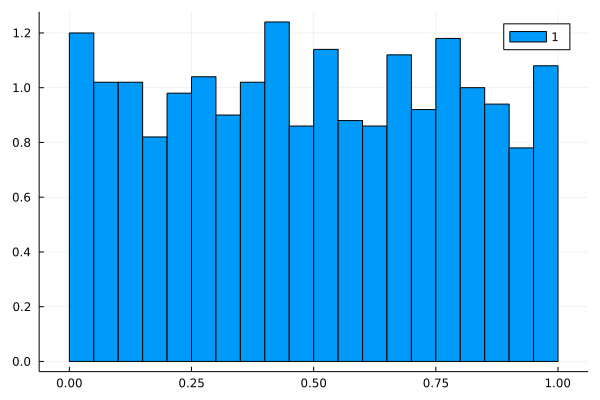

In [227]:
anim =  @animate for i in 1:200
    histogram(v[i, :], bins = 40, label = "$i", normalize = true)
end 
gif(anim, "tutorial_anim_fps30.gif", fps = 5)

The next issue is how we can make the function orbit for a vector more generic, to work with generic types. To do so we will use parametric functions. The function will depend from a parameter, that has to be known at compile time, as the type of the element of our Vector, or the number of its indices (called its dimension).

In [228]:
function orbit(f, x::Vector{T}, n) where {T} # this where T means that this is a parametric type
    k = length(x)
    v = Array{T, 2}(undef, (n, k)) 
    v[1, :] = x
    for i in 2:n
        x = f.(x)
        v[i, :] = x
    end
    return v
end

orbit (generic function with 4 methods)

In [229]:
v = orbit(f, rand(BigFloat, 1000), 200) # now, this works, the compiler sees that the input is a vector of 
# BigFloat, so checks if there is a parametric function that he can compile, sees that T = BigFloat and
# substitutes T in the text of the function and compiles it consequently.
# After the first run, once it is compiled, it is really fast !!!

200×1000 Matrix{BigFloat}:
 0.738561   0.259865    0.407854   …  0.0548267   0.975678   0.942859
 0.772356   0.769341    0.966036      0.207283    0.0949228  0.215505
 0.70329    0.709821    0.13124       0.657267    0.34365    0.67625
 0.834693   0.8239      0.456065      0.901068    0.902219   0.875744
 0.551923   0.580355    0.992279      0.356577    0.352881   0.435267
 0.989216   0.974172    0.0306458  …  0.91772     0.913424   0.983238
 0.0426703  0.100643    0.118827      0.302041    0.316323   0.0659222
 0.163398   0.362057    0.418827      0.843248    0.865051   0.246306
 0.546797   0.923887    0.973644      0.528722    0.466953   0.742557
 0.99124    0.281278    0.102646      0.9967      0.995631   0.764664
 0.0347325  0.808644    0.368439   …  0.0131559   0.0173978  0.719812
 0.134105   0.618957    0.930767      0.0519313   0.0683806  0.806731
 0.464483   0.943397    0.257758      0.196938    0.254819   0.623665
 ⋮                                 ⋱                         
 

┌ Info: Saved animation to 
│   fn = /home/isaia/code/JuliaDSTutorial/tutorial_anim_fps30.gif
└ @ Plots /home/isaia/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/isaia/code/JuliaDSTutorial/tutorial_anim_fps30.gif")
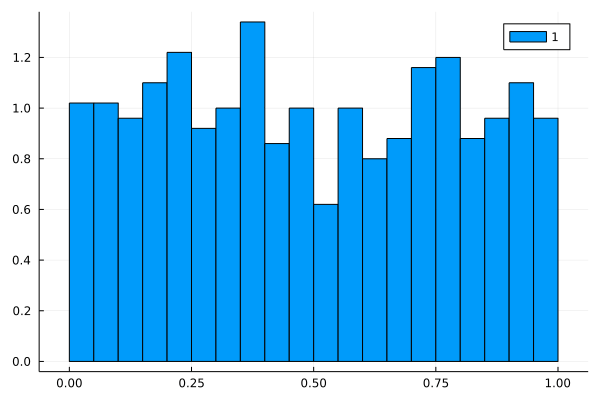

In [230]:
anim =  @animate for i in 1:200
    histogram(v[i, :], bins = 40, label = "$i", normalize = true)
end 
gif(anim, "tutorial_anim_fps30.gif", fps = 5)

#### Exercise 4 
Fill in the missing part in the following function, which is a further generalization of orbit, where we can give as an input a matrix or an $N$-index array of initial points and it returns an $N+1$-index array of orbits.
Substitute $\Omega$ for the right expression involving $N$.  

In [175]:
# this function returns a tuple of (: , :, :, :, ...) that we are going to use to access all the information
# in the multiindex below
fill_colon(N) = ntuple(x-> :, N)

function orbit(f, x::Array{T, N}, n) where {T, N} # now also N is a parameter
    k = size(x)
    v = Array{T, Ω}(undef, (n, k...)) # substitute Ω for an expression with N
    
    l = fill_colon(N) 
    v[1, l...] = x # the ... notation means we are taking the tuple and filling in as argument 2,..., N+1
                    # of the multiindex
    for i in 2:n
        x = f.(x)
        v[i, l...] = x
    end
    return v
end

orbit (generic function with 5 methods)

Now test it here!

In [35]:
orbit(f, rand(BigFloat, (10, 10)), 20)

LoadError: MethodError: no method matching -(::Int64, ::Matrix{BigFloat})
For element-wise subtraction, use broadcasting with dot syntax: scalar .- array
[0mClosest candidates are:
[0m  -(::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) at int.jl:85
[0m  -(::T, [91m::T[39m) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at int.jl:86
[0m  -(::Union{Int16, Int32, Int64, Int8}, [91m::BigInt[39m) at gmp.jl:536
[0m  ...

### Structures and types in Julia

It is possible to declare composite types in Julia. 

In [231]:
struct WorldCoordinate
    latitude
    longitude
    timezone
end

In [232]:
RJ = WorldCoordinate(-22.9, -43.19, "GMT-3")

WorldCoordinate(-22.9, -43.19, "GMT-3")

In [233]:
RJ.latitude # remark that pressing tab you get autocompletion

-22.9

In [234]:
RJ.timezone

"GMT-3"

Suppose now that we know how to compute a timezone from coordinates (without worrying about the real timezone lines, which are complicated and daylight saving time).

In [235]:
function timezone(latitude, longitude)  
    val = Int64(floor(longitude/15))
    if val<0
        val = abs(val)
        return "GMT-$val" #the $ symbol makes $val be substituted by val
    elseif val>0
        return "GMT+$val"
    else
        return "GMT-0"
    end
end

timezone (generic function with 1 method)

We can now define a new constructor for the object.

In [236]:
WorldCoordinate(a, b) = WorldCoordinate(a, b, timezone(a, b))

WorldCoordinate

In [237]:
WorldCoordinate(-22, -43) #this returns the object as above, but computes some of its attributes automatically

WorldCoordinate(-22, -43, "GMT-3")

# Numerical experiments in ergodic theory

## Why we call this Numerical Experiments

These are called numerical experiments, since, due to the finite nature of floating point arithmetic, the behavior of the discretized map and of the abstract dynamical system may be different.

There are many articles that deal with this topic, as:
- [Lanford, Oscar E., III Informal remarks on the orbit structure of discrete approximations to chaotic maps](https://people.math.harvard.edu/~knill/history/lanford/papers/LanfordOrbit.pdf)
- [Guineheuf-Monge Discrepancy and discretizations of circle expanding maps I: theory](https://arxiv.org/abs/2206.07991)
- [Guineheuf-Monge Discrepancy and discretizations of circle expanding maps II: simulations](https://arxiv.org/abs/2206.08000)
- [Galatolo-N-Rojas Probability, statistics and computation in dynamical systems](https://www.cambridge.org/core/journals/mathematical-structures-in-computer-science/article/abs/probability-statistics-and-computation-in-dynamical-systems/E20AF291F13006D356DD854F500A1853)


We change the dynamic now into something uniformly expanding.

In [238]:
g(x) = mod(2*x+0.1*sin(2*pi*x), 1)

g (generic function with 2 methods)

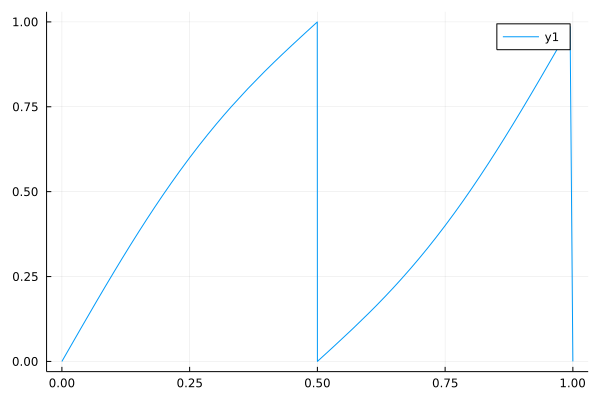

In [239]:
plot(g, 0, 1)

In [240]:
v = orbit(g, rand(Float64, 1000), 400)

400×1000 Matrix{Float64}:
 0.600277    0.239016   0.6734     …  0.768846   0.321505   0.423326
 0.141634    0.577793   0.25816       0.438393   0.733087   0.892986
 0.36097     0.108631   0.616188      0.914535   0.366738   0.723685
 0.798601    0.280339   0.165687      0.777916   0.80776    0.348735
 0.501829    0.658866   0.417666      0.457366   0.522033   0.778836
 0.00250888  0.233683   0.884787   …  0.941201   0.0302667  0.459308
 0.00659407  0.56684    0.703343      0.846291   0.0794362  0.943907
 0.0173301   0.0929073  0.310953      0.610333   0.206737   0.853294
 0.0455276   0.240931   0.714661      0.156762   0.509802   0.626919
 0.119272    0.581699   0.331776      0.39685    0.0134496  0.18228
 0.306666    0.11429    0.75064    …  0.854068   0.0353398  0.455644
 0.70706     0.294376   0.401281      0.628762   0.0927023  0.938798
 0.317737    0.68489    0.860688      0.185162   0.240413   0.840082
 ⋮                                 ⋱                        
 0.280473    0.56

┌ Info: Saved animation to 
│   fn = /home/isaia/code/JuliaDSTutorial/tutorial_anim_fps30.gif
└ @ Plots /home/isaia/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/isaia/code/JuliaDSTutorial/tutorial_anim_fps30.gif")
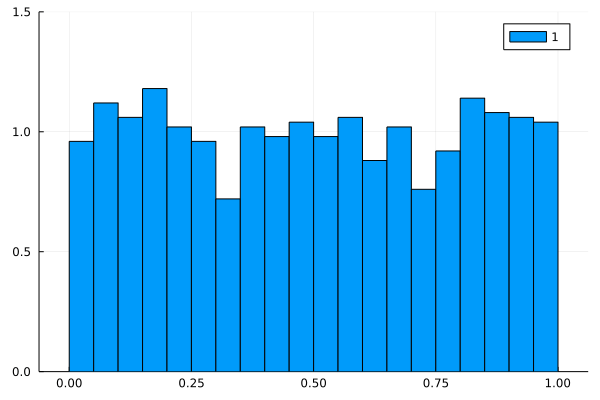

In [241]:
anim =  @animate for i in 1:400
    histogram(v[i, :], bins = 40, label = "$i", normalize = true, ylims = (0, 1.5) )
end 
gif(anim, "tutorial_anim_fps30.gif", fps = 5)

So, up to know we have a way to compute the orbits, we want to compute some Birkhoff averages of some observables.
Remark that the code I'm writing is storing a lot of objects in memory and can be made more efficient.

The empirical Birkhoff average along a orbit of length $N$ is
$$
\frac{1}{N} \sum_{i=0}^{N-1}\phi(f^i(x))
$$
we will compute the Birkhoff averages for $1000$ starting points along orbits of length $400$.

In [242]:
ϕ(x) = sin(x)+x^2 #ϕ is written by writing \phi and pressing tab

ϕ (generic function with 1 method)

In [243]:
function BirkhoffAverages(ϕ, v)
    w = ϕ.(v) # we evaluate the observables on the orbit
    k, n = size(w)
    z = accumulate(+, w; dims = 1) # this computes the accumulated sums along columns 
    t = [x for x in 1:k]
    z = z./t # we divide the first line by 1, the second by 2, the third by 3, etc...
    return z
end 

BirkhoffAverages (generic function with 1 method)

In [244]:
z = BirkhoffAverages(ϕ, v)

400×1000 Matrix{Float64}:
 0.925203  0.293875  1.07711   0.889057  …  1.28643   0.419361  0.59
 0.543212  0.586948  0.699531  0.508631     0.951552  0.812972  1.08319
 0.523302  0.431371  0.785559  0.465835     1.17725   0.706337  1.11741
 0.731012  0.412346  0.637265  0.626969     1.20968   0.873557  0.953892
 0.731382  0.539142  0.625827  0.574101     1.0979    0.853078  1.02492
 0.609905  0.49698   0.78096   0.655986  …  1.19727   0.716095  0.963149
 0.523724  0.548594  0.832461  0.606294     1.23552   0.626033  1.06853
 0.460462  0.492695  0.778735  0.64548      1.19929   0.57878   1.12016
 0.414587  0.470913  0.821776  0.59111      1.08611   0.597571  1.10455
 0.386449  0.512603  0.783178  0.578765     1.0319    0.539177  1.01555
 0.387311  0.477558  0.825214  0.646045  …  1.07294   0.493487  0.9821
 0.45083   0.469161  0.802414  0.648123     1.06549   0.460793  1.04094
 0.447948  0.517815  0.856004  0.731526     1.00033   0.448109  1.07244
 ⋮                                      

┌ Info: Saved animation to 
│   fn = /home/isaia/code/JuliaDSTutorial/BirkhoffAverages.gif
└ @ Plots /home/isaia/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/isaia/code/JuliaDSTutorial/BirkhoffAverages.gif")
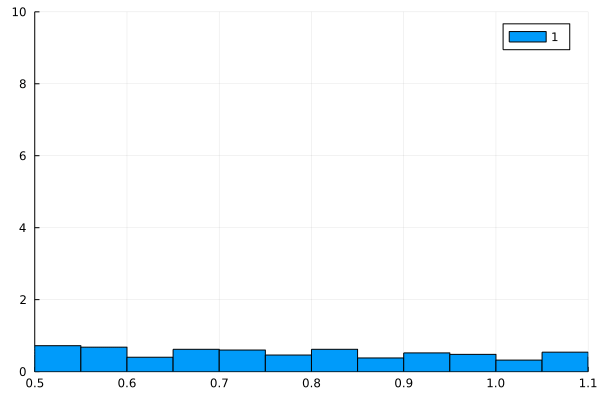

In [245]:
anim = @animate for i in 1:400
    histogram(z[i, :], bins = 40, label = "$i", xlims = (0.5, 1.1), ylims = (0, 10), normalize = true)
end 
gif(anim, "BirkhoffAverages.gif", fps = 5)

This animations shows the CLT in action for uniformly expanding maps. As $N$ grows the Birkhoff averages distribute as a Gaussian with average the Birkhoff average of the observable.

### Automatic Differentiation and computing the Lyapunov exponent

The package DualNumbers permits us to compute automatically the derivatives of a function (Automatic Derivation, AD for short).

In [246]:
using Pkg;
Pkg.add("DualNumbers") # You will need to run this only once, to install the package

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [fa6b7ba4] + DualNumbers v0.6.8
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [247]:
using DualNumbers # this brings the AD package into namespace

A dual number is a number that consists of two components, called value and epsilon; we can think of a dual number as the "jet" of a function, i.e.,

```Dual(0, 1.0)```

can be thought of $0+x$ in a neighborhood of $0$. 
The relation between derivatives become therefore operators between dual numbers.
$$(a+\epsilon a')+(b+\epsilon b') = a+b+\epsilon (a'+b')$$
$$(a+\epsilon a')\cdot (b+\epsilon b') = a\cdot b+\epsilon (a\cdot b'+a'\cdot  b)$$

Overloading the operators and the functions to work with Dual numbers allows us to compute automatically derivatives.

In [248]:
x  = Dual(0.1, 1.0)

0.1 + 1.0ɛ

In [249]:
sin(x)

0.09983341664682815 + 0.9950041652780258ɛ

In [250]:
f(x)

0.36000000000000004 + 3.2ɛ

As you can see, the epsilon part is nothing else than $\cos(0.1)=(\sin)'(0.1)$.
We will use this to define automatically $\log(|T'|)$.

In [251]:
ψ(x, h) = log(abs(h(Dual(x, 1)).epsilon))

ψ (generic function with 1 method)

We will now specialize it to our dynamic.

In [252]:
ϕ(x) = ψ(x, g)

ϕ (generic function with 1 method)

In [253]:
z = BirkhoffAverages(ϕ, v)

400×1000 Matrix{Float64}:
 0.400333  0.714581  0.535987  0.374228  …  0.729589  0.546449  0.36686
 0.636966  0.541434  0.606452  0.639387     0.539478  0.602853  0.639883
 0.580592  0.664723  0.54645   0.625622     0.670358  0.554243  0.639941
 0.631294  0.656487  0.61996   0.611231     0.689398  0.615403  0.602826
 0.568249  0.626499  0.570818  0.613349     0.617967  0.556404  0.631903
 0.634593  0.642882  0.626436  0.598583  …  0.67332   0.624008  0.581722
 0.681957  0.601766  0.62237   0.61243      0.699638  0.668685  0.634553
 0.717328  0.642289  0.615607  0.585401     0.664251  0.681865  0.663609
 0.743912  0.649911  0.616257  0.617983     0.685257  0.641314  0.639363
 0.759536  0.622259  0.607174  0.604815     0.657217  0.673732  0.656934
 0.742958  0.648008  0.615104  0.618567  …  0.676381  0.699798  0.627536
 0.731519  0.644234  0.597005  0.5941       0.657411  0.718659  0.654303
 0.717881  0.637727  0.618509  0.622052     0.669184  0.718137  0.669267
 ⋮                        

┌ Info: Saved animation to 
│   fn = /home/isaia/code/JuliaDSTutorial/BirkhoffAverages.gif
└ @ Plots /home/isaia/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/isaia/code/JuliaDSTutorial/BirkhoffAverages.gif")
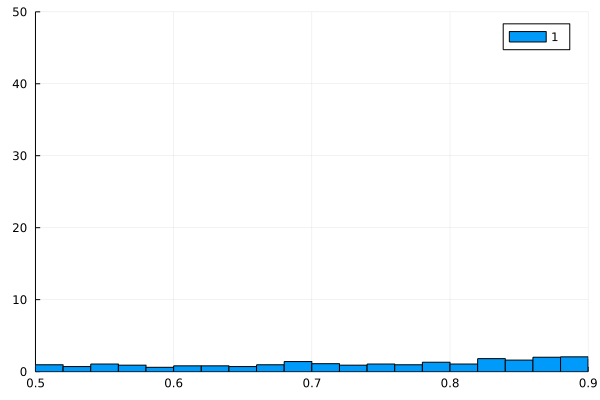

In [254]:
anim = @animate for i in 1:400
    histogram(z[i, :], bins = 40, label = "$i", xlims = (0.5, 0.9), ylims = (0, 50), normalize = true)
end 
gif(anim, "BirkhoffAverages.gif", fps = 5)

### Systems with noise

We want now do similar computations for systems with additive noise, i.e., the iterated of the system
are
$$X_i = T(X_{i-1})+\theta$$
where $\theta$ is a uniformly distributed random variable in $[-\xi, \xi]$.

The system we are going to study is a family of one-dimensional systems on $[-1,1]$; please note that
the noise could bring us outside $[-1, 1]$ so we need to set boundary conditions.
We will set periodic boundary conditions.
The following function applys the boundary conditions.

In [266]:
function BC(x)
    if x>1
        return 1-(x-1)
    elseif x<0 
        return abs(x)
    else 
        return x
    end
end

BC (generic function with 1 method)

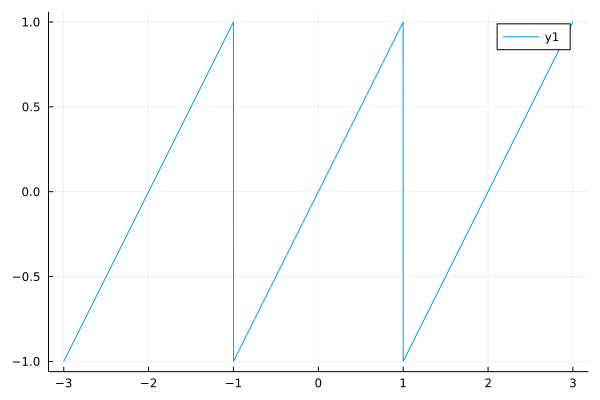

In [267]:
plot(periodic, -3, 3)

In [268]:
function orbit_with_noise(f, x::Vector{T}, ξ, n) where {T} # this where T means that this is a parametric type
    k = length(x)
    v = Array{T, 2}(undef, (n, k)) 
    
    v[1, :] = x
    for i in 2:n
        noise = ξ*(2*rand(T, k).-1.0)
        #@info sum(noise)
        x = BC.(f.(x)+noise)
        v[i, :] = x
    end
    return v
end

orbit_with_noise (generic function with 1 method)

We will now look at the dynamic of a classical map, the BZ-map.

In [278]:
a_big = big"0.5060735690368223513195993710530479569801417368282037493809901142182256388277859"
b_big = big"0.02328852830307032054478158044023918735669943648088852646123182739831022528"
c_big = big"0.121205692738975111744666848150620569782497212127938371936404761693002104361"


function BZ(x; T = Float64, a = T(a_big, RoundNearest), b = T(b_big, RoundNearest), c = T(c_big, RoundNearest))
    if 0<=x<=1/8
        return (a-abs(x-1/8)^(1/3))*exp(-x)+b
    elseif 1/8<x<0.3
        return (a+abs(x-1/8)^(1/3))*exp(-x)+b
    else
        return c*(10*x*exp((-10/3)*x))^(19)+b
    end
end

BZ (generic function with 1 method)

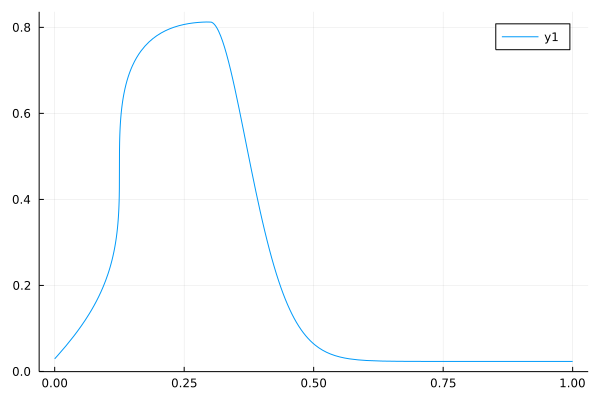

In [279]:
plot(BZ, 0, 1)

In [286]:
ξ = 0.873*10^(-4)/2

v = orbit_with_noise(BZ, rand(Float64, 200), 0.05, 100000);

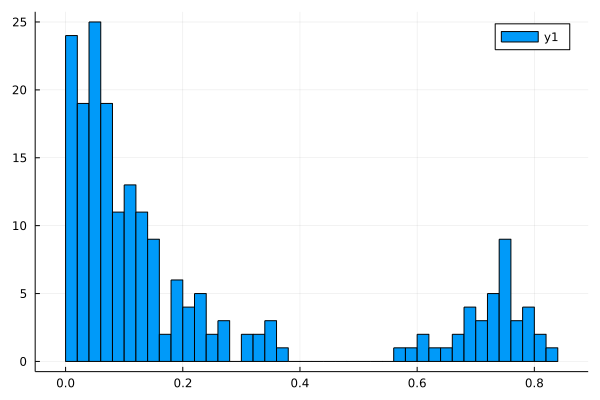

In [283]:
histogram(v[end, :], bins = 40)

In [275]:
ϕ(x) = ψ(x, BZ) # log(|BZ'|)

ϕ (generic function with 1 method)

In [285]:
z = BirkhoffAverages(ϕ, v)

100000×200 Matrix{Float64}:
 -13.4142   -16.6942   -2.3433    …  -1.30898    -0.0826318   0.509263
  -6.49185   -8.08672  -0.994848     -0.502686    0.559919    0.651345
  -4.04191   -5.07084  -0.448957     -0.0758823   0.354868    0.985711
  -2.57099   -3.75715   0.4446       -0.133282   -1.5713     -0.206026
  -2.89573   -4.92718   0.222235     -2.12067    -1.1867     -0.103136
  -2.35634   -4.0535    0.322586  …  -1.71387    -0.887151    0.039773
  -1.90546   -3.41157   0.245397     -1.39139    -0.607446    0.15719
  -1.71182   -2.78517  -0.812339     -1.09249    -0.623426   -0.853133
  -2.59566   -2.62054  -0.68376      -0.81674    -1.50889    -0.725136
  -2.28322   -3.42277  -0.5607       -1.24855    -1.32575    -0.612187
  -1.97134   -3.06259  -0.352046  …  -1.10174    -1.17713    -0.41229
  -1.77228   -2.65496  -0.793383     -0.964591   -1.03337    -0.50883
  -2.16055   -2.83112  -0.709214     -0.679024   -0.813057   -1.31991
   ⋮                              ⋱                  

┌ Info: Saved animation to 
│   fn = /home/isaia/code/JuliaDSTutorial/BirkhoffAverages.gif
└ @ Plots /home/isaia/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/isaia/code/JuliaDSTutorial/BirkhoffAverages.gif")
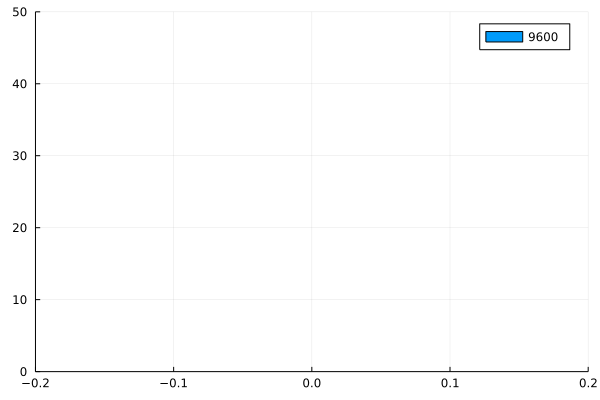

In [284]:
anim = @animate for i in 9600:10000
    histogram(z[i, :], bins = 40, label = "$i", xlims = (0.06, 0.01), ylims = (0, 50), normalize = true)
end 
gif(anim, "BirkhoffAverages.gif", fps = 5)

In [86]:
v = orbit_with_noise(h, rand(Float64, 200), 0.3, 10000)

10000×200 Matrix{Float64}:
  0.857702   0.0857116   0.165554  …   0.658962    0.54463     0.142877
 -0.193802   0.834333    0.869675     -0.678266   -0.778213    0.86313
  0.997913   0.0763216   0.246293     -0.584911   -0.357434   -0.171123
 -0.812947   0.986529   -0.914955      0.902291    0.938465   -0.813391
 -0.336632   0.932402    0.395635     -0.0524697   0.373009   -0.416914
  0.933892   0.691844    0.728589  …   0.752487   -0.778605    0.984001
  0.164416  -0.386881   -0.501626     -0.524807   -0.723072    0.844331
  0.821197  -0.737744   -0.96386       0.799227   -0.408093   -0.0943881
 -0.467026  -0.753274    0.476899     -0.108305   -0.996503    0.800337
  0.911677  -0.775148   -0.685212      0.963687   -0.97524    -0.628245
  0.288503  -0.681309   -0.715363  …   0.483672    0.822955   -0.555592
 -0.709459  -0.495248   -0.476946     -0.66831     0.0446826  -0.830396
 -0.476363  -0.723352    0.972308     -0.773153    0.774806   -0.223558
  ⋮                                ⋱ 

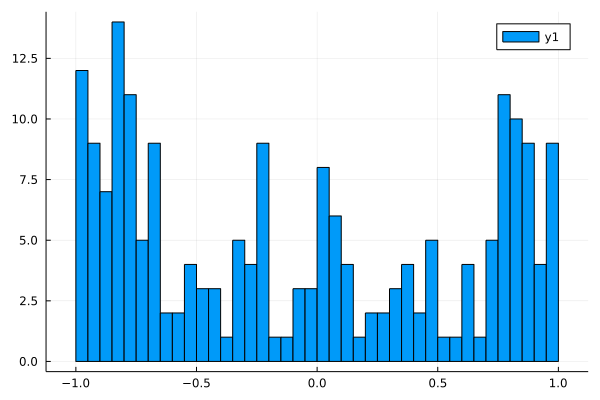

In [87]:
histogram(v[end, :], bins = 40)

In [88]:
z = BirkhoffAverages(ϕ, v)

10000×200 Matrix{Float64}:
  1.68859    -7.52448   -4.89126    …   0.634225  -0.128006   -5.4805
 -1.28625    -2.97319   -1.57361        0.691973   0.58578    -1.88334
 -0.0927546  -4.645     -2.14985        0.513783  -0.213692   -2.84186
  0.298991   -2.92167   -1.12563        0.858166   0.351867   -1.76229
 -0.171302   -1.93281   -1.18179       -1.21097   -0.0469121  -1.64922
  0.195416   -1.47251   -0.812161   …  -0.814955   0.177837   -1.00133
 -0.53519    -1.47586   -0.761425      -0.738006   0.296089   -0.626038
 -0.278964   -1.15563   -0.396828      -0.469987   0.0987708  -1.44013
 -0.330512   -0.897308  -0.425983      -1.14984    0.342082   -1.12326
 -0.10419    -0.679199  -0.304337      -0.819391   0.528104   -0.966606
 -0.337411   -0.547669  -0.189149   …  -0.799702   0.618564   -0.883124
 -0.231829   -0.54438   -0.228289      -0.675512  -0.277158   -0.679599
 -0.265051   -0.425032  -0.0422473     -0.52559   -0.157221   -0.911149
  ⋮                                 ⋱         

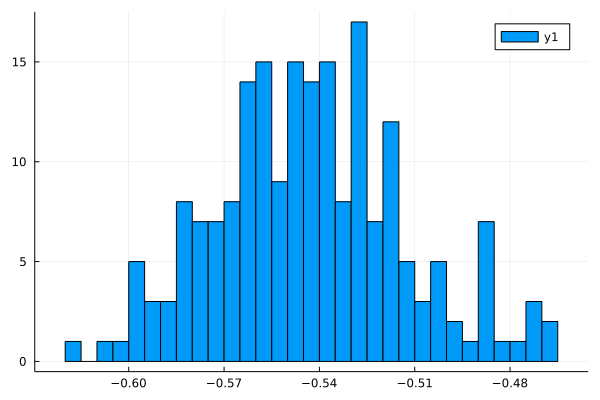

In [89]:
histogram(z[end, :], bins = 40)

# Final comments

In this notebook we saw many non-rigorous tools to investigate dynamical systems with Julia. We used histograms to see how orbits distribute in the interval $[0, 1]$ under the action of the dynamics.

We showed how to compute orbits, how to approximate the Birkhoff averages of observables and how to approximate an important quantity, the Lyapunov exponent (associated to the Physical measure).

We showed how this can be computed with various methods and different precisions, but all of these methods do not study the true dynamics, but a floating point approximation of it.
To show this, I will show one last example.

In [90]:
doubling(x) = mod(2*x, 1)

doubling (generic function with 1 method)

In [98]:
v = orbit(doubling, Float64(π)/4, 52)

52-element Vector{Float64}:
 0.7853981633974483
 0.5707963267948966
 0.14159265358979312
 0.28318530717958623
 0.5663706143591725
 0.13274122871834493
 0.26548245743668986
 0.5309649148733797
 0.061929829746759424
 0.12385965949351885
 0.2477193189870377
 0.4954386379740754
 0.9908772759481508
 ⋮
 0.4091796875
 0.818359375
 0.63671875
 0.2734375
 0.546875
 0.09375
 0.1875
 0.375
 0.75
 0.5
 0.0
 0.0

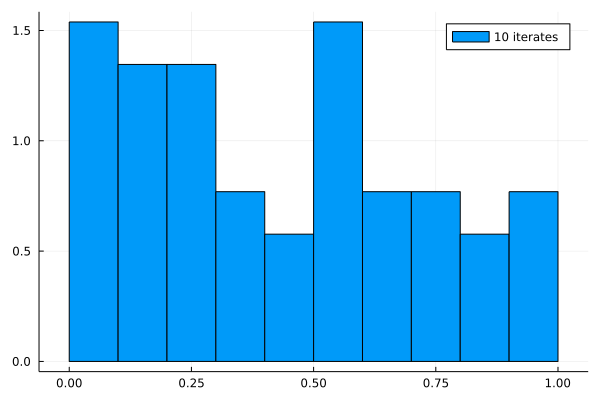

In [99]:
histogram(v, bins = 10, normalize = true, label = "10 iterates")

In [100]:
v = orbit(doubling, Float64(π)/4, 500)

500-element Vector{Float64}:
 0.7853981633974483
 0.5707963267948966
 0.14159265358979312
 0.28318530717958623
 0.5663706143591725
 0.13274122871834493
 0.26548245743668986
 0.5309649148733797
 0.061929829746759424
 0.12385965949351885
 0.2477193189870377
 0.4954386379740754
 0.9908772759481508
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

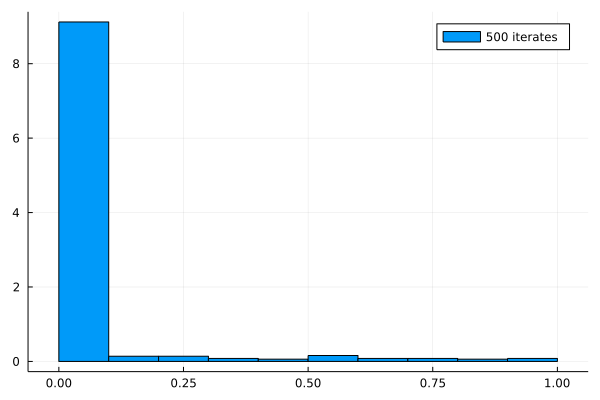

In [101]:
histogram(v, bins = 10, normalize = true, label = "500 iterates")

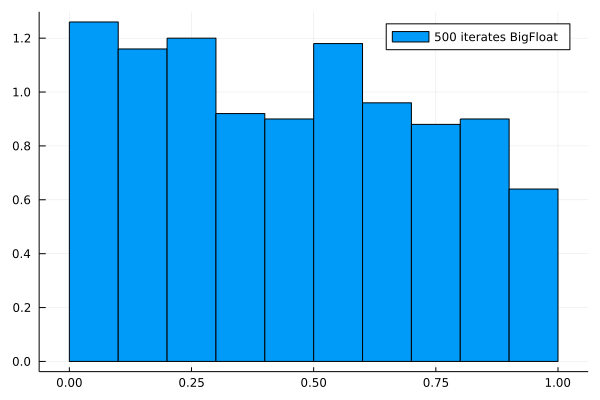

In [115]:
setprecision(1024)
v = orbit(doubling, BigFloat(π)/4, 500);
histogram(v, bins = 10, normalize = true, label = "500 iterates BigFloat")

The issue is that the computer represents numbers in base $2$ and the map $2x\, mod\, 1$ acts as a shift in base $2$; due to the fact that the the computer is a finite machine and pads with $0$, for any floating point number all the orbits converge to $0$ in a number of iterates equal to the precision. 

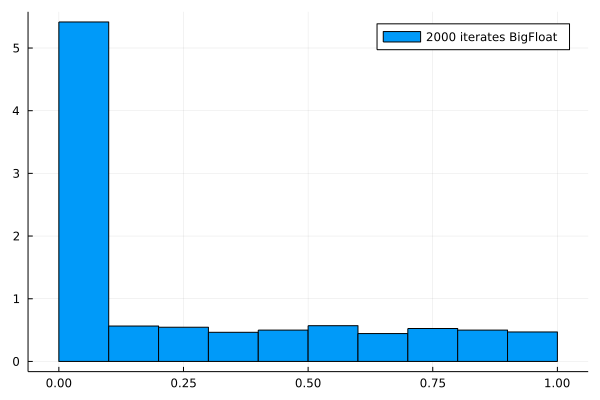

In [102]:
setprecision(1024)
v = orbit(doubling, BigFloat(π)/4, 2000);
histogram(v, bins = 10, normalize = true, label = "2000 iterates BigFloat")

The number $\pi/4$ has infinite binary expansion, and a mathematical analysis of the orbit of $\pi/4$ under the action of the dynamics shows that it does not land on $0$ but its binary representation does.
In general, since we have only a finite number of floating point numbers, for any dynamics $f$ its floating point representation has only preperiodic orbits (by Pidgeon Hole Principle). 


This is a strong motivation for looking for other tools to understand the statistichal behaviour of a dynamical system, through the use of tools from Functional Analysis.

I will present them in the next days, starting tomorrow from Interval Arithmetics, a tool that allows us to do Validated numerical computations.